In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2" 


import torch_geometric
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, GraphUNet
from torch_geometric.data import Batch
from torch_geometric.utils import to_dense_adj


from utils.data import GraphDataModule
from utils.training import train_model
from utils.metrics import evaluate_model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
data_module = GraphDataModule("./data", num_workers=1)
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

Loading data from disk


Converting vectors to graphs:   0%|          | 0/133 [00:00<?, ?it/s]

Converting vectors to graphs: 100%|██████████| 34/34 [00:00<00:00, 346.06it/s]


In [4]:
class SuperResMLP(nn.Module):
    def __init__(self, num_nodes_input, num_nodes_output, num_hidden_nodes, n_layers):
        super().__init__()
        self.num_nodes_input = num_nodes_input
        self.num_nodes_output = num_nodes_output
        input_size = ((num_nodes_input+1)*(num_nodes_input))//2
        output_size = ((num_nodes_output+1)*(num_nodes_output))//2
        hidden_size = ((num_hidden_nodes+1)*(num_hidden_nodes))//2
        self.input_layer = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
        )      
        
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_layers - 1):
            self.hidden_layers.append(
                nn.Sequential(
                    nn.Linear(in_features=hidden_size, out_features=hidden_size),
                    nn.BatchNorm1d(num_features=hidden_size),
                    nn.Dropout(p=0.1),
                    nn.ReLU()
                )
            )

        self.output_layer = nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=output_size),
            nn.Sigmoid(),
        )


    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, samples: Batch):
        x = to_dense_adj(samples.edge_index, batch=samples.batch)
        batch_size = x.shape[0]
        mask = torch.triu(torch.ones_like(x[0])).bool()
        x = x[:, mask]
        x = self.input_layer(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)

        # Initialize output matrix batch
        
        matrix = torch.zeros((batch_size, self.num_nodes_output, self.num_nodes_output), device=x.device)

        # Create mask for upper triangular part
        mask = torch.triu(torch.ones(self.num_nodes_output, self.num_nodes_output)).bool().to(x.device)

        # Fill upper triangular part
        matrix[:, mask] = x

        # Mirror upper triangular to lower triangular (make symmetric)
        matrix = matrix + matrix.transpose(1, 2) - torch.diag_embed(torch.diagonal(matrix, dim1=1, dim2=2))

        return matrix


In [5]:
batch,target_batch = next(iter(train_loader))
input_dim = batch[0].x.shape[0]
output_dim = target_batch[0].x.shape[0]


In [6]:
model = SuperResMLP(input_dim, output_dim, num_hidden_nodes=(input_dim+output_dim)//2, n_layers=1).to(device)

In [7]:
criterion = nn.MSELoss()

train_loss_history, val_loss_history, lr_history, best_model_state_dict = train_model(
    model=model, 
    train_dataloader=train_loader, 
    val_dataloader=val_loader,
    criterion=criterion,
    num_epochs=100,
)

Epoch loss 0.17106887698173523:  58%|█████▊    | 58/100 [00:53<00:38,  1.09it/s, train_loss=0.223, val_loss=0.381, lr=1e-5]  


In [ ]:
model.load_state_dict(best_model_state_dict)
loss = evaluate_model(model, val_loader)
print(loss)

torch.save(model, 'model.pth')

0.19527285


In [ ]:
model = torch.load("model.pth", weights_only=False)

In [10]:
batch = batch.to(device)
output = model(batch)

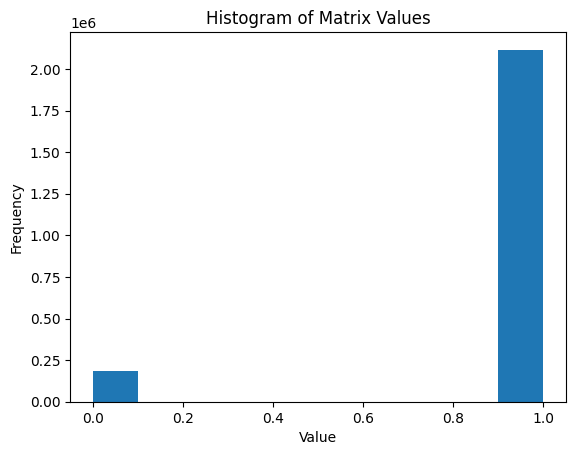

In [11]:

flat_matrix = output.detach().cpu().numpy().flatten()


# Plot histogram
plt.hist(flat_matrix, density=False) 
plt.title("Histogram of Matrix Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()